# Logistic Regression with a Neural Network

In [1]:
#Import required libraries for Systemml. No spark libraries are imported as this 
#notebook is instanciated using pyspark
import systemml as sml
from systemml import MLContext, dml
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Create Systemml context
ml = MLContext(spark)

## Overview of the Problem set ##

**Problem Statement**: You are given a dataset  containing:
    - a training set of 209 images labeled as cat (y=1) or non-cat (y=0)
    - a test set of 50 images labeled as cat or non-cat
    - each image is of shape (64,64, 3) where 3 is for the 3 channels (RGB). 

These images are flattened to a vector of size 64x64x3 = 12288. And all channel values are normalized by dividing by 255.  The dataset provided is already messaged and sotred as csv in HDFS.

In [3]:
#Load the data. 
train_set_x_rdd = sc.textFile("trainx.csv")
train_set_y_rdd = sc.textFile("trainy.csv")
test_set_x_rdd = sc.textFile("testx.csv")
test_set_y_rdd = sc.textFile("testy.csv")

## Here we create our required functions in systemml
* Sigmoid - Activation function
* Initialize_with_zero - Setup input parameters and matrices to zero
* propagate - Calculate cost and gradients
* optimize - Iterate to obtain weight and intercept vectors
* predict - Use calculated weights to predict input values
* model - Put all of above fucntion to use

In the output from systemml we emit back input y (train and test) vectors as well.  This was just for convenience to use these values as numpy arrays in calculating accuracy and then plot these.

In [5]:
sml_text = """
sigmoid = function(matrix[double] A) return (matrix[double] B) {
    B = 1/(1 + exp(-A))
}

initialize_with_zeros = function(double dim) return (matrix[double] w,double b) {
    w = matrix(0.0,dim,1)
    b = 0.0
}

propagate = function(matrix[double] w,double b,matrix[double] X,matrix[double] Y) return 
    ( matrix[double] dw, double db, double cost) {
        m = ncol(X)
        A = sigmoid(t(w)%*%X + b)
        cost = -(Y%*%t(log(A))  + (1-Y)%*%t(log(1-A)))/m
        dw = (X%*%t(A-Y))/m
        db = sum(A-Y)/m
        cost = as.scalar(cost)
}

optimize = function (matrix[double] w,double b,matrix[double] X,matrix[double] Y, 
        double num_iterations, double learning_rate, boolean print_cost) return 
        (matrix[double] w, double b, matrix[double] dw,double db, matrix[double] costs ) {
            costs = matrix(0,num_iterations,1)
            m = ncol(X)
            for (i in 1:num_iterations) {
                [dw,db, cost] = propagate(w, b, X, Y)
                w = w - learning_rate*dw
                b = b - learning_rate*db
                costs[i,] = cost
                if (i %% 100 == 0) {
                    print ('Cost after iteration %d: %f',i, cost) 
                }
            }
}

predict = function (matrix[double] w,double b,matrix[double] X)  return (matrix[double] Y_prediction) {
        m = ncol(X)
        A = sigmoid(t(w)%*%X + b)
        Y_prediction = matrix(0.0,1,m)
        Y_prediction = A > 0.5
}  

model = function (matrix[double] X_train,matrix[double] Y_train,matrix[double] X_test,matrix[double] Y_test, 
                double num_iterations, double learning_rate, boolean print_cost) return 
                (matrix[double] w, double b, matrix[double] Y_prediction_test,matrix[double] Y_test,
                matrix[double] Y_prediction_train,matrix[double] Y_train, matrix[double] costs ) {
        
                [w, b] = initialize_with_zeros(nrow(X_train))
        
                [w,b,dw,db,costs] = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
        
                Y_prediction_test = predict(w, b, X_test)
                Y_prediction_train = predict(w, b, X_train)
}
[w,b,y_predict_test,y_test,y_predict_train,y_train,costs] = model(train_set_x, train_set_y, test_set_x, test_set_y, 
            num_iterations, learning_rate, print_cost)
"""

sml_script = dml(sml_text).input(train_set_x = train_set_x_rdd, train_set_y=train_set_y_rdd, 
                                    test_set_x=test_set_x_rdd, test_set_y=test_set_y_rdd, 
                                    num_iterations=2000, learning_rate=0.005, print_cost=True).output(
                                    "y_predict_test","y_predict_train","costs","y_test","y_train")
yp_test, yp_train,costs,y_test,y_train = ml.execute(sml_script).get("y_predict_test","y_predict_train","costs"
                                                            ,"y_test","y_train")

[Stage 8:>                                                          (0 + 2) / 2]
                                                                                
[Stage 20:>                                                         (0 + 2) / 2]
                                                                                
Cost after iteration 100: 0.644898
Cost after iteration 200: 0.484894
Cost after iteration 300: 0.377761
Cost after iteration 400: 0.331775
Cost after iteration 500: 0.303529
Cost after iteration 600: 0.280094
Cost after iteration 700: 0.260226
Cost after iteration 800: 0.243100
Cost after iteration 900: 0.228144
Cost after iteration 1000: 0.214944
Cost after iteration 1100: 0.203189
Cost after iteration 1200: 0.192644
Cost after iteration 1300: 0.183124
Cost after iteration 1400: 0.174481
Cost after iteration 1500: 0.166597
Cost after iteration 1600: 0.159374
Cost after iteration 1700: 0.152731
Cost after iteration 1800: 0.146601
Cost after iteration 1900: 0.140927
C

In [6]:
print "Train set accuracy :", 100 - np.mean(np.abs(yp_train.toNumPy() - y_train.toNumPy())) * 100
print "Train set accuracy :", 100 - np.mean(np.abs(yp_test.toNumPy() - y_test.toNumPy())) * 100

Train set accuracy : 99.04306220095694
Train set accuracy : 70.0


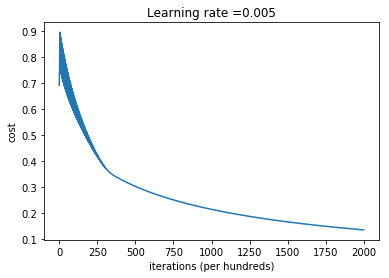

In [7]:
plt.plot(costs.toNumPy())
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + "0.005")
plt.show()